# 1️⃣ 데이터 가져오기

All files will be stored in the PARQUET format. Please see the ‘Working With PARQUET Format’ under the Data Dictionaries and MetaData section.
Trip data will be published **monthly** (**with two months delay**) instead of bi-annually.
HVFHV files will now include 17 more columns (please see High Volume FHV Trips Dictionary for details). Additional columns will be added to the old files as well. The earliest date to include additional columns: February 2019.
Yellow trip data will now include 1 additional column (‘airport_fee’, please see Yellow Trips Dictionary for details). The additional column will be added to the old files as well. The earliest date to include the additional column: January 2011.

매년 1월 1일에 전년도 데이터를 받아와서 분석  
- 예) 만약 오늘이 2023-01-01이라면 2022년도 데이터를 모두 받아와서 분석.
- 택시데이터가 open되기까지는 약 3개월 정도 delay가 있음.
- 즉 2022-12월 데이터를 받기위해서는 2023-3월까지 기다려야 한다는 말.
- 그러므로 **매년 3월**에 전년도 데이터를 받아오기로 하자.  

In [1]:
# import requests
# from bs4 import BeautifulSoup
# import urllib
# import pandas as pd
# import datetime

# today = datetime.date.today()
# today_year = today.year -1

# url = 'https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page'
# res = requests.get(url)
# soup = BeautifulSoup(res.content, 'html.parser')
# parquet_link = soup.find_all('a',{'title':'Yellow Taxi Trip Records', 'href':True})
# parquet_link

# for link in parquet_link:
#     file_link = link.get('href')
#     file_name = file_link.split('/')[-1]
#     folder_path = '/home/ubuntu/working/spark-example/data/taxi_parquet/'
#     download_path = folder_path + file_name
#     # print(file_name)
#     # anlaysis_link = []
#     if str(today_year) in file_link:
#         response = requests.get(file_link)
#         with open(download_path, 'wb') as file:
#             file.write(response.content)
#             print(f'{file_name} 다운로드 완료')



In [19]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('taxi').getOrCreate()

taxi_filepath = '/home/ubuntu/working/taxi_analysis/data/taxi_parquet/*.parquet'
zone_filepath = '/home/ubuntu/working/taxi_analysis/data/taxi_parquet/taxi+_zone_lookup.csv'

In [20]:
taxi_df = spark.read.parquet(f'file:///{taxi_filepath}')
zone_df = spark.read.csv(f'file:///{zone_filepath}', inferSchema=False, header=True)

print(f'• taxi_df의 shape : {taxi_df.count()}, {len(taxi_df.columns)}')
print(f'• zone_df의 shape : {zone_df.count()}, {len(zone_df.columns)}')

print('• taxi_df의 schema')
print(taxi_df.printSchema())
print('• zone_df의 schema')
print(zone_df.printSchema())

• taxi_df의 shape : 39656098, 19
• zone_df의 shape : 265, 4
• taxi_df의 schema
root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: double (nullable = true)

None
• zone_df의 schema
root
 |-- LocationID: string (nullable 

# 2️⃣ total table 만들기
- zone_df와 taxi_df의 join
  - zone_df의 `LocationID` == taxi_df의 `PULocationID`
  - zone_df의 `LocationID` == taxi_df의 `DOLocationID`

In [29]:
taxi_df.createOrReplaceTempView('taxi')
zone_df.createOrReplaceTempView('zone')

In [32]:
query = """
        SELECT 
            t.VendorID as vendor_id,
            TO_DATE(t.tpep_pickup_datetime) as pickup_date,
            TO_DATE(t.tpep_dropoff_datetime) as dropoff_date,
            HOUR(t.tpep_pickup_datetime) as pickup_time,
            HOUR(t.tpep_dropoff_datetime) as dropoff_time,
            t.passenger_count,
            t.trip_distance,
            t.fare_amount,
            t.tip_amount,
            t.tolls_amount,
            t.total_amount,
            t.payment_type,
            pz.Zone as pickup_zone,
            dz.Zone as dropoff_zone
        FROM taxi t
            LEFT JOIN zone pz
            ON t.PULocationID = pz.LocationID
            LEFT JOIN zone dz
            ON t.DOLocationID = dz.LocationID
"""

comb_df = spark.sql(query)
comb_df.createOrReplaceTempView('comb')

In [34]:
print(f'comb_df의 shape: {comb_df.count()}, {len(comb_df.columns)}')
comb_df.printSchema()

comb_df의 shape: 39656098, 14
root
 |-- vendor_id: long (nullable = true)
 |-- pickup_date: date (nullable = true)
 |-- dropoff_date: date (nullable = true)
 |-- pickup_time: integer (nullable = true)
 |-- dropoff_time: integer (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- pickup_zone: string (nullable = true)
 |-- dropoff_zone: string (nullable = true)



# 3️⃣이상치 제거를 위한 통계 data 확인

### ① total_amount 확인
- total_amount가 음수인 것은 말이 되지 않음 -> total_amount>0이상이어야 함.
- `total_amount 이상치 有`

In [40]:
comb_df.select('total_amount').describe().show()

+-------+------------------+
|summary|      total_amount|
+-------+------------------+
|  count|          39656098|
|   mean|21.671268443330536|
| stddev| 96.37360220544845|
|    min|           -2567.8|
|    max|         401095.62|
+-------+------------------+



### ② trip_distance 확인

In [41]:
comb_df.select("trip_distance").describe().show()

+-------+-----------------+
|summary|    trip_distance|
+-------+-----------------+
|  count|         39656098|
|   mean|5.959398968097749|
| stddev|599.1907143779277|
|    min|              0.0|
|    max|        389678.46|
+-------+-----------------+



### ③ passenger_count 확인

In [42]:
comb_df.select('passenger_count').describe().show()

+-------+------------------+
|summary|   passenger_count|
+-------+------------------+
|  count|          38287795|
|   mean|1.4011492173942115|
| stddev|0.9628938026962094|
|    min|               0.0|
|    max|               9.0|
+-------+------------------+



### ④ pickup year확인
- 2022년 데이터만 가져왔기 때문에 그 외의 년도는 이상치이다.
- `이상치 有`

In [45]:
query = """
        SELECT YEAR(pickup_date) as year, 
                count(*) as cnt
        FROM comb
        GROUP BY year
        ORDER BY year
"""

spark.sql(query).show()

+----+--------+
|year|     cnt|
+----+--------+
|2001|       6|
|2002|     439|
|2003|      11|
|2009|      74|
|2012|       1|
|2022|39610696|
|2023|   44871|
+----+--------+



### ⑤ pickup month 확인

In [48]:
query = """
        SELECT MONTH(pickup_date) as month, count(*) as cnt
        FROM comb
        GROUP BY month
        ORDER BY month
        
"""
spark.sql(query).show()

+-----+-------+
|month|    cnt|
+-----+-------+
|    1|2464401|
|    2|2971227|
|    3|3610732|
|    4|3601690|
|    5|3597409|
|    6|3556748|
|    7|3192298|
|    8|3138840|
|    9|3172370|
|   10|3689465|
|   11|3244910|
|   12|3416008|
+-----+-------+



### 최종 전처리 쿼리

In [46]:
query = """
        SELECT *
        FROM comb
        WHERE (total_amount BETWEEN 0 AND 5000)
        AND trip_distance < 100
        AND passenger_count < 4
        AND pickup_date BETWEEN '2022-01-01' AND '2022-12-31'
"""

final_df = spark.sql(query)
final_df.createOrReplaceTempView('final')

In [47]:
final_df.show()

+---------+-----------+------------+-----------+------------+---------------+-------------+-----------+----------+------------+------------+------------+--------------------+--------------------+
|vendor_id|pickup_date|dropoff_date|pickup_time|dropoff_time|passenger_count|trip_distance|fare_amount|tip_amount|tolls_amount|total_amount|payment_type|         pickup_zone|        dropoff_zone|
+---------+-----------+------------+-----------+------------+---------------+-------------+-----------+----------+------------+------------+------------+--------------------+--------------------+
|        1| 2022-03-01|  2022-03-01|          9|           9|            1.0|          2.4|       10.0|       0.0|         0.0|        13.8|           2|            Flatiron|             Seaport|
|        1| 2022-03-01|  2022-03-01|          9|          10|            1.0|          2.2|       10.5|       0.0|         0.0|        14.3|           2|     Lower East Side|            Union Sq|
|        2| 2022-03-

# 4️⃣ 시각화

In [50]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

### ① 시계열 데이터(승객수 변화)

In [51]:
final_df.columns

['vendor_id',
 'pickup_date',
 'dropoff_date',
 'pickup_time',
 'dropoff_time',
 'passenger_count',
 'trip_distance',
 'fare_amount',
 'tip_amount',
 'tolls_amount',
 'total_amount',
 'payment_type',
 'pickup_zone',
 'dropoff_zone']

In [52]:
query = """
    SELECT pickup_date, count(*) as cnt
    FROM final
    GROUP BY pickup_date
    ORDER BY pickup_date
"""

df_pickup = spark.sql(query).toPandas()
df_pickup

,pickup_date,cnt
0,2022-01-01,31518
1,2022-01-02,50003
2,2022-01-03,63064
3,2022-01-04,67657
4,2022-01-05,69716
...,...,...
359,2022-12-27,70606
360,2022-12-28,79113
361,2022-12-29,82657
362,2022-12-30,84248


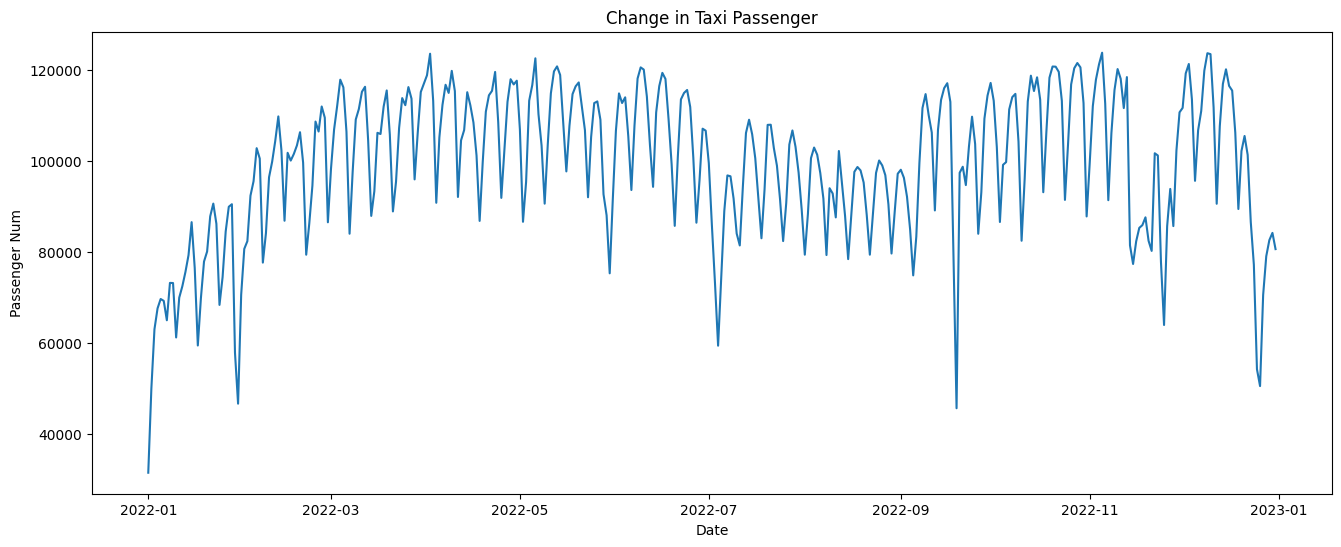

In [58]:
plt.figure(figsize=(16,6))
plt.plot(df_pickup['pickup_date'], df_pickup['cnt'])
plt.xlabel('Date')
plt.ylabel('Passenger Num')
plt.title('Change in Taxi Passenger')
plt.show()


# searborn으로 그리는 법
# plt.figure(figsize=(14,4))
# sns.lineplot(x='pickup_date', y='cnt', data=df_pickup)

### ② 요일 별 승객 수

In [61]:
df_pickup.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364 entries, 0 to 363
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   pickup_date  364 non-null    object
 1   cnt          364 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.8+ KB


In [64]:
df_pickup['day'] = pd.to_datetime(df_pickup['pickup_date']).dt.day_name()
df_pickup.head()

,pickup_date,cnt,day
0,2022-01-01,31518,Saturday
1,2022-01-02,50003,Sunday
2,2022-01-03,63064,Monday
3,2022-01-04,67657,Tuesday
4,2022-01-05,69716,Wednesday


<Axes: xlabel='day', ylabel='cnt'>

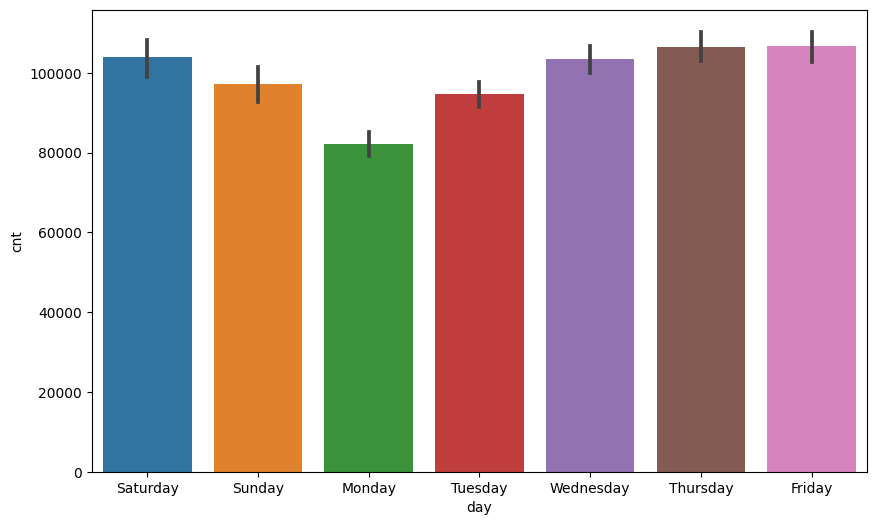

In [66]:
plt.figure(figsize=(10,6))
sns.barplot(x= 'day', y = 'cnt' ,data =df_pickup)

### ③ payment_type의 수

In [71]:
final_df.take(5)

[Row(vendor_id=1, pickup_date=datetime.date(2022, 3, 1), dropoff_date=datetime.date(2022, 3, 1), pickup_time=9, dropoff_time=9, passenger_count=1.0, trip_distance=2.4, fare_amount=10.0, tip_amount=0.0, tolls_amount=0.0, total_amount=13.8, payment_type=2, pickup_zone='Flatiron', dropoff_zone='Seaport'),
 Row(vendor_id=1, pickup_date=datetime.date(2022, 3, 1), dropoff_date=datetime.date(2022, 3, 1), pickup_time=9, dropoff_time=10, passenger_count=1.0, trip_distance=2.2, fare_amount=10.5, tip_amount=0.0, tolls_amount=0.0, total_amount=14.3, payment_type=2, pickup_zone='Lower East Side', dropoff_zone='Union Sq'),
 Row(vendor_id=2, pickup_date=datetime.date(2022, 3, 1), dropoff_date=datetime.date(2022, 3, 1), pickup_time=9, dropoff_time=9, passenger_count=1.0, trip_distance=19.78, fare_amount=52.0, tip_amount=11.06, tolls_amount=0.0, total_amount=67.61, payment_type=1, pickup_zone='JFK Airport', dropoff_zone='West Village'),
 Row(vendor_id=2, pickup_date=datetime.date(2022, 3, 1), dropoff_d

In [73]:
query = """
        SELECT payment_type, count(*) as cnt
        FROM final
        GROUP BY payment_type
"""

df_pay = spark.sql(query).toPandas()
df_pay

,payment_type,cnt
0,5,6
1,1,28652082
2,3,137173
3,2,7259117
4,4,97601


In [74]:
payment_type_to_string = {
    1: "Credit Card",
    2: "Cash",
    3: "No Charge",
    4: "Dispute",
    5: "Unknown",
    6: "Voided Trip",
}

df_pay.index = df_pay['payment_type'].map(payment_type_to_string)
df_pay

,payment_type,cnt
payment_type,,
Unknown,5,6
Credit Card,1,28652082
No Charge,3,137173
Cash,2,7259117
Dispute,4,97601


<Axes: xlabel='payment_type', ylabel='cnt'>

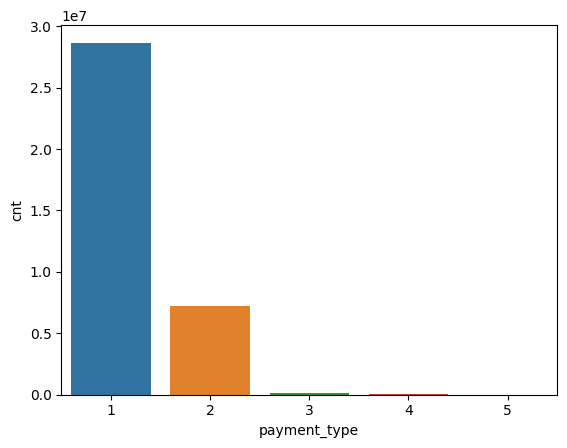

In [75]:
sns.barplot(x='payment_type', y='cnt',data=df_pay)

payment type은 아래의 순으로 많다
- Credit Card > Cash > No Charge > Dispute> Unkown

In [77]:
spark.stop()

Bad pipe message: %s [b'"Google Chrome";v="119", "Chromium";v="119", "Not?A_Brand']
Bad pipe message: %s [b'v="24"\r\nsec-ch-ua-mobile: ?0\r\nsec', b'h-ua-platform: "Windows"\r\nUpgrade-Insecure-R', b'uests: 1\r\nUser-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Geck', b' Chrome/119.0.0.0 Safari/537.36\r\nAccept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,imag', b'webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7\r\nSec-Fetch-Site: none\r\nSec-Fetch-Mo', b': navigate\r\nSec-Fetch-User: ?1\r\nSec-Fetch-Dest: document\r\nAccept-Encoding: gzip, deflate, br\r\nAccep', b'Language: ko-KR,ko;q=0.9,en-US;q=0.8,en;q=0.7\r\nCookie: _xsrf=2|a3368e8b|d025e14b663de067fda55e1e56256bdb|1700187581', b'username-127-0-0-1-8888="2|1:0|10:1700187699|23:username-1']
Bad pipe message: %s [b'-0-0-1-8888|200:eyJ1c2VybmFtZSI6ICI2YzIyOGEyMmIwN', b'0NDE5OGJjYmRlMTNiZDZkZGZmYiIsICJuYW1lIjogIkFub255bW91cyBFdXJ5ZG9tZSIsICJkaXNwbGF5X2', b'bWUiO